# Genetic Feature Selection nodes in TPOT2

TPOT2 can use evolutionary algorithms to optimize feature selection simultaneously with pipeline optimization. It includes two node search spaces with different feature selection strategies: FSSNode and GeneticFeatureSelectorNode. 

1. FSSNode - (Feature Set Selector) This node is useful if you have a list of predefined feature sets you want to select from. Each FeatureSetSelector Node will select a single group of features to be passed to the next step in the pipeline. Note that FSSNode does not create its own subset of features and does not mix/match multiple predefined feature sets.

2. GeneticFeatureSelectorNode—Whereas the FSSNode selects from a predefined list of subsets of features, this node uses evolutionary algorithms to optimize a novel subset of features from scratch. This is useful where there is no predefined grouping of features. 

This tutorial focuses on FSSNode. See Tutorial 5 for more information on GeneticFeatureSelectorNode.

It may also be beneficial to pair these search spaces with a secondary objective function to minimize complexity. That would encourage TPOT to try to produce the simplest pipeline with the fewest number of features.

tpot2.objectives.number_of_nodes_objective - This can be used as an other_objective_function that counts the number of nodes.

tpot2.objectives.complexity_scorer - This is a scorer that tries to count the total number of learned parameters (number of coefficients, number of nodes in decision trees, etc.).


# Feature Set Selector

The FeatureSetSelector is a subclass of sklearn.feature_selection.SelectorMixin that simply returns the manually specified columns. The parameter sel_subset specifies the name or index of the column that it selects. The transform function then simply indexes and returns the selected columns. You can also optionally name the group with the name parameter, though this is only for note keeping and does is not used by the class.


    sel_subset: list or int
        If X is a dataframe, items in sel_subset list must correspond to column names
        If X is a numpy array, items in sel_subset list must correspond to column indexes
        int: index of a single column




In [1]:
import tpot2
import pandas as pd
import numpy as np
#make a dataframe with columns a,b,c,d,e,f

#numpy array where columns are 1,2,3,4,5,6
data = np.repeat([np.arange(6)],10,0)

df = pd.DataFrame(data,columns=['a','b','c','d','e','f'])
fss = tpot2.builtin_modules.FeatureSetSelector(name='test',sel_subset=['a','b','c'])

print("original DataFrame")
print(df)
print("Transformed Data")
print(fss.fit_transform(df))

original DataFrame
   a  b  c  d  e  f
0  0  1  2  3  4  5
1  0  1  2  3  4  5
2  0  1  2  3  4  5
3  0  1  2  3  4  5
4  0  1  2  3  4  5
5  0  1  2  3  4  5
6  0  1  2  3  4  5
7  0  1  2  3  4  5
8  0  1  2  3  4  5
9  0  1  2  3  4  5
Transformed Data
[[0 1 2]
 [0 1 2]
 [0 1 2]
 [0 1 2]
 [0 1 2]
 [0 1 2]
 [0 1 2]
 [0 1 2]
 [0 1 2]
 [0 1 2]]


# FSSNode

The `FSSNode` is a node search space that simply selects one feature set from a list of feature sets. This works identically to the EstimatorNode, but provides a easier interface for defining the feature sets.

Note that the FSS is only well defined when used as the first step in a pipeline. This is because downstream nodes will receive different transformations of the data such that the original indexes no longer correspond to the same columns in the transformed data.

The `FSSNode` takes in a single parameter `subsets` which defines the groups of features. There are four ways of defining the subsets. 

    subsets : str or list, default=None
            Sets the subsets that the FeatureSetSeletor will select from if set as an option in one of the configuration dictionaries. 
            Features are defined by column names if using a Pandas data frame, or ints corresponding to indexes if using numpy arrays.
            - str : If a string, it is assumed to be a path to a csv file with the subsets. 
                The first column is assumed to be the name of the subset and the remaining columns are the features in the subset.
            - list or np.ndarray : If a list or np.ndarray, it is assumed to be a list of subsets (i.e a list of lists).
            - dict : A dictionary where keys are the names of the subsets and the values are the list of features.
            - None : If None, each column will be treated as a subset. One column will be selected per subset.


Lets say you want to have three groups of features, each with three columns each. The following examples are equivalent:

### str

sel_subsets=simple_fss.csv


    \# simple_fss.csv
    group_one, 1,2,3
    group_two, 4,5,6
    group_three, 7,8,9


### dict


sel_subsets = { "group_one" :  [1,2,3],
            "group_two" :  [4,5,6],
            "group_three" :  [7,8,9],
            }


### list


sel_subsets = [[1,2,3],
[4,5,6],
[7,8,9]]

# Examples

For these examples, we create a dummy dataset where the first six columns are informative and the rest are uninformative.

In [2]:
import tpot2
import sklearn.datasets
from sklearn.linear_model import LogisticRegression
import numpy as np
import pandas as pd
import tpot2
import sklearn.datasets
from sklearn.linear_model import LogisticRegression
import numpy as np
from tpot2.search_spaces.nodes import *
from tpot2.search_spaces.pipelines import *
from tpot2.config import get_search_space


X, y = sklearn.datasets.make_classification(n_samples=1000, n_features=6, n_informative=6, n_redundant=0, n_repeated=0, n_classes=2, n_clusters_per_class=2, weights=None, flip_y=0.01, class_sep=1.0, hypercube=True, shift=0.0, scale=1.0, shuffle=True, random_state=None)
X = np.hstack([X, np.random.rand(X.shape[0],6)]) #add six uninformative features
X = pd.DataFrame(X, columns=['a','b','c','d','e','f','g','h','i', 'j', 'k', 'l']) # a, b ,c the rest are uninformative
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, train_size=0.75, test_size=0.25)

X.head()

,a,b,c,d,e,f,g,h,i,j,k,l
0,2.607470,-1.799163,-1.345319,-3.155746,-1.731663,0.699546,0.513305,0.507864,0.357858,0.439859,0.695061,0.449589
1,0.045796,-2.830673,1.578201,-0.098472,-0.665334,-0.130451,0.022118,0.808068,0.158917,0.328156,0.349374,0.927755
2,0.490722,-2.026190,-1.848381,-1.112946,-1.620822,3.430459,0.166742,0.504127,0.942156,0.556877,0.024859,0.430831
3,-1.859338,-0.196734,1.525634,0.244376,-0.685690,1.995038,0.055226,0.751830,0.983152,0.702334,0.750200,0.294415
4,-0.056101,1.386592,1.552356,1.446347,-0.984449,0.742441,0.631411,0.217660,0.124121,0.814294,0.131921,0.917958


Lets say that either based on prior knowledge or interest, we know that the features can be grouped as follows

In [3]:
subsets = { "group_one" :  ['a','b','c',],
            "group_two" :  ['d','e','f'],
            "group_three" :  ['g','h','i'],
            "group_four" :  ['j','k','l'],
            }

We can create an FSSNode that will select from this subset. Each node in a pipeline only selects one subset.

In [4]:
fss_search_space = FSSNode(subsets=subsets)

If we randomly sample from this search space, we can see that we get a single selector that selects one of the predefined sets. In this case, it selects groups two, which includes ['d', 'e', 'f']. (A random seed was set in the generate function so that the same group would be selected when rerunning the notebook.)

In [5]:
fss_selector = fss_search_space.generate(rng=1).export_pipeline()
fss_selector

FeatureSetSelector(name='group_two', sel_subset=['d', 'e', 'f'])

In [6]:
fss_selector.set_output(transform="pandas") #by default sklearn selectors return numpy arrays. this will make it return pandas dataframes
fss_selector.fit(X_train)
fss_selector.transform(X_train)

,d,e,f
221,2.819930,-0.677731,-2.883151
121,-0.068495,-1.398128,1.239476
83,2.225071,-1.902156,1.425918
243,2.592917,0.764790,-2.120585
992,2.329279,2.362780,-3.780878
...,...,...,...
254,1.850187,-2.177608,-4.088455
19,-0.949434,1.062798,-3.421324
956,2.105221,-0.169633,1.743979
150,2.171954,-1.343100,-0.346960


We can now use this when defining our pipelines. 
For this first example, we will construct a simple linear pipeline where the first step is a feature set selector, and the second is a classifier

In [7]:

classification_search_space = get_search_space(["RandomForestClassifier"])
fss_and_classifier_search_space = SequentialPipeline([fss_search_space, classification_search_space])


est = tpot2.TPOTEstimator(generations=5, 
                            scorers=["roc_auc_ovr", tpot2.objectives.complexity_scorer],
                            scorers_weights=[1.0, -1.0],
                            n_jobs=32,
                            classification=True,
                            search_space = fss_and_classifier_search_space,
                            verbose=1,
                            )


scorer = sklearn.metrics.get_scorer('roc_auc_ovo')
est.fit(X_train, y_train)
print(scorer(est, X_test, y_test))

Generation: 100%|██████████| 5/5 [00:30<00:00,  6.12s/it]


0.8989320638188367


In [8]:
est.fitted_pipeline_

Pipeline(steps=[('featuresetselector',
                 FeatureSetSelector(name='group_two',
                                    sel_subset=['d', 'e', 'f'])),
                ('randomforestclassifier',
                 RandomForestClassifier(class_weight='balanced',
                                        max_features=0.7587731972584,
                                        min_samples_leaf=7,
                                        min_samples_split=12,
                                        n_estimators=128))])

With this setup TPOT is able to identify one of the subsets used, but the performance is not optimal. In this case we happen to know that multiple feature sets are required. If we want to include multiple features in our pipelines, we will have to modify our search space. There are three options for this.

1. UnionPipeline - This allows you to have a fixed number of feature sets selected. If you use a UnionPipeline with two FSSNodes, you will always select two feature sets that are simply concatenated together.
2. DynamicUnionPipeline - This space allows multiple FSSNodes to be selected. Unlike UnionPipeline you don't have to specify the number of selected sets, TPOT will identify the number of sets that are optimal. Additionally, with DynamicUnionPipeline, the same feature set cannot be selected twice. Note that while DynamicUnionPipeline can select multiple feature sets, it never mixes two feature sets together.
3. GraphSearchPipeline - When set as the leave_search_space, GraphSearchPipeline can also select multiple FSSNodes which act as an input to the rest of the pipeline.

####  UnionPipeline + FSSNode example

In [9]:
union_fss_space = UnionPipeline([fss_search_space, fss_search_space])

In [10]:
# this union search space will always select exactly two fss_search_space
selector1 = union_fss_space.generate(rng=1).export_pipeline()
selector1

FeatureUnion(transformer_list=[('featuresetselector-1',
                                FeatureSetSelector(name='group_two',
                                                   sel_subset=['d', 'e', 'f'])),
                               ('featuresetselector-2',
                                FeatureSetSelector(name='group_three',
                                                   sel_subset=['g', 'h',
                                                               'i']))])

In [11]:
selector1.set_output(transform="pandas") 
selector1.fit(X_train)
selector1.transform(X_train)

,d,e,f,g,h,i
221,2.819930,-0.677731,-2.883151,0.420393,0.930431,0.223210
121,-0.068495,-1.398128,1.239476,0.583717,0.872967,0.355258
83,2.225071,-1.902156,1.425918,0.521714,0.624303,0.526185
243,2.592917,0.764790,-2.120585,0.748397,0.099224,0.640145
992,2.329279,2.362780,-3.780878,0.233820,0.054463,0.025899
...,...,...,...,...,...,...
254,1.850187,-2.177608,-4.088455,0.955017,0.363270,0.010256
19,-0.949434,1.062798,-3.421324,0.094215,0.837656,0.856361
956,2.105221,-0.169633,1.743979,0.266365,0.446727,0.356117
150,2.171954,-1.343100,-0.346960,0.712673,0.983344,0.873176


####  DynamicUnionPipeline + FSSNode example
The dynamic union pipeline may select a variable number of feature sets.

In [12]:
dynamic_fss_space = DynamicUnionPipeline(fss_search_space)
dynamic_fss_space.generate(rng=1).export_pipeline()

FeatureUnion(transformer_list=[('featuresetselector',
                                FeatureSetSelector(name='group_three',
                                                   sel_subset=['g', 'h',
                                                               'i']))])

In [13]:
dynamic_fss_space.generate(rng=3).export_pipeline()

FeatureUnion(transformer_list=[('featuresetselector-1',
                                FeatureSetSelector(name='group_one',
                                                   sel_subset=['a', 'b', 'c'])),
                               ('featuresetselector-2',
                                FeatureSetSelector(name='group_four',
                                                   sel_subset=['j', 'k',
                                                               'l']))])

#### GraphSearchPipeline + FSSNode example

FSSNodes must be set as the leaf search space as they act as the inputs to the pipeline.

Here is an example pipeline from this search space that utilizes two feature sets.

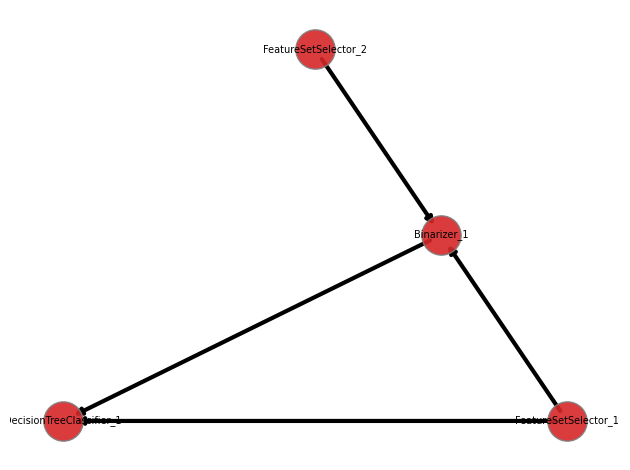

In [14]:
graph_search_space = tpot2.search_spaces.pipelines.GraphSearchPipeline(
    leaf_search_space = fss_search_space,
    inner_search_space = tpot2.config.get_search_space(["transformers"]),
    root_search_space= tpot2.config.get_search_space(["KNeighborsClassifier", "LogisticRegression", "DecisionTreeClassifier"]),
    max_size = 10,
)

graph_search_space.generate(rng=4).export_pipeline().plot()

#### Optimize with TPOT

For this example, we will optimize the DynamicUnion search space

In [15]:
import tpot2
import sklearn.datasets
from sklearn.linear_model import LogisticRegression
import numpy as np


final_classification_search_space = SequentialPipeline([dynamic_fss_space, classification_search_space])

est = tpot2.TPOTEstimator(generations=5, 
                            scorers=["roc_auc_ovr", tpot2.objectives.complexity_scorer],
                            scorers_weights=[1.0, -1.0],
                            n_jobs=32,
                            classification=True,
                            search_space = final_classification_search_space,
                            verbose=1,
                            )


scorer = sklearn.metrics.get_scorer('roc_auc_ovo')

est.fit(X_train, y_train)
print(scorer(est, X_test, y_test))

Generation: 100%|██████████| 5/5 [00:34<00:00,  6.96s/it]


0.9916366443643849


We can see that this pipeline performed slightly better and correctly identified group one and group two as the feature sets used in the generative equation.

In [16]:
est.fitted_pipeline_

Pipeline(steps=[('featureunion',
                 FeatureUnion(transformer_list=[('featuresetselector-1',
                                                 FeatureSetSelector(name='group_one',
                                                                    sel_subset=['a',
                                                                                'b',
                                                                                'c'])),
                                                ('featuresetselector-2',
                                                 FeatureSetSelector(name='group_two',
                                                                    sel_subset=['d',
                                                                                'e',
                                                                                'f']))])),
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=False,
                                        class_weight='balanced',
                                        max_features=0.3314976075207,
                                        min_samples_leaf=3,
                                        min_samples_split=15,
                                        n_estimators=128))])

### Getting Fancy

If you want to get fancy, you can combine more search spaces in order to set up unique preprocessing pipelines per feature set. Here's an example:

In [36]:
dynamic_transformers = DynamicUnionPipeline(get_search_space("all_transformers"), max_estimators=4)
dynamic_transformers_with_passthrough = tpot2.search_spaces.pipelines.UnionPipeline([
    dynamic_transformers,
    tpot2.config.get_search_space("Passthrough")],
    )
multi_step_engineering = DynamicLinearPipeline(dynamic_transformers_with_passthrough, max_length=4)
fss_engineering_search_space = SequentialPipeline([fss_search_space, multi_step_engineering])
union_fss_engineering_search_space = DynamicUnionPipeline(fss_engineering_search_space)

final_fancy_search_space = SequentialPipeline([union_fss_engineering_search_space, classification_search_space])

In [40]:
final_fancy_search_space.generate(rng=3).export_pipeline()

Pipeline(steps=[('featureunion',
                 FeatureUnion(transformer_list=[('pipeline-1',
                                                 Pipeline(steps=[('featuresetselector',
                                                                  FeatureSetSelector(name='group_one',
                                                                                     sel_subset=[0,
                                                                                                 1,
                                                                                                 2])),
                                                                 ('pipeline',
                                                                  Pipeline(steps=[('featureunion',
                                                                                   FeatureUnion(transformer_list=[('featureunion',
                                                                                                                   FeatureUnion(transformer_list=[('pca',
                                                                                                                                                   PCA(n_components=0.93113403057))])),
                                                                                                                  ('passthrough...
                                                                                   FeatureUnion(transformer_list=[('featureunion',
                                                                                                                   FeatureUnion(transformer_list=[('quantiletransformer',
                                                                                                                                                   QuantileTransformer(n_quantiles=87)),
                                                                                                                                                  ('columnonehotencoder',
                                                                                                                                                   ColumnOneHotEncoder())])),
                                                                                                                  ('passthrough',
                                                                                                                   Passthrough())]))]))]))])),
                ('randomforestclassifier',
                 RandomForestClassifier(class_weight='balanced',
                                        criterion='entropy',
                                        max_features=0.021545996678,
                                        min_samples_leaf=11,
                                        n_estimators=128))])

# Other examples

## dictionary

In [17]:
import tpot2
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
import sklearn

subsets = { "group_one" :  ['a','b','c'],
            "group_two" :  ['d','e','f'],
            "group_three" :  ['g','h','i'],
            }

fss_search_space = tpot2.search_spaces.nodes.FSSNode(subsets=subsets)

selector = fss_search_space.generate(rng=1).export_pipeline()
selector.set_output(transform="pandas")
selector.fit(X_train)
selector.transform(X_train)

,d,e,f
221,2.819930,-0.677731,-2.883151
121,-0.068495,-1.398128,1.239476
83,2.225071,-1.902156,1.425918
243,2.592917,0.764790,-2.120585
992,2.329279,2.362780,-3.780878
...,...,...,...
254,1.850187,-2.177608,-4.088455
19,-0.949434,1.062798,-3.421324
956,2.105221,-0.169633,1.743979
150,2.171954,-1.343100,-0.346960


## list

In [18]:
import tpot2
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
import sklearn

subsets = [['a','b','c'],['d','e','f'],['g','h','i']]

fss_search_space = tpot2.search_spaces.nodes.FSSNode(subsets=subsets)

selector = fss_search_space.generate(rng=1).export_pipeline()
selector.set_output(transform="pandas")
selector.fit(X_train)
selector.transform(X_train)

,d,e,f
221,2.819930,-0.677731,-2.883151
121,-0.068495,-1.398128,1.239476
83,2.225071,-1.902156,1.425918
243,2.592917,0.764790,-2.120585
992,2.329279,2.362780,-3.780878
...,...,...,...
254,1.850187,-2.177608,-4.088455
19,-0.949434,1.062798,-3.421324
956,2.105221,-0.169633,1.743979
150,2.171954,-1.343100,-0.346960


## csv file

note: watch for spaces in the csv file!

In [19]:
import tpot2
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
import sklearn

subsets = 'simple_fss.csv'
'''
# simple_fss.csv
one,a,b,c
two,d,e,f
three,g,h,i
'''

fss_search_space = tpot2.search_spaces.nodes.FSSNode(subsets=subsets)

selector = fss_search_space.generate(rng=1).export_pipeline()
selector.set_output(transform="pandas")
selector.fit(X_train)
selector.transform(X_train)

,d,e,f
221,2.819930,-0.677731,-2.883151
121,-0.068495,-1.398128,1.239476
83,2.225071,-1.902156,1.425918
243,2.592917,0.764790,-2.120585
992,2.329279,2.362780,-3.780878
...,...,...,...
254,1.850187,-2.177608,-4.088455
19,-0.949434,1.062798,-3.421324
956,2.105221,-0.169633,1.743979
150,2.171954,-1.343100,-0.346960


All of the above is the same when using numpy data, but the column names are replaced int indexes.

In [20]:
import tpot2
import sklearn.datasets
from sklearn.linear_model import LogisticRegression
import numpy as np
import pandas as pd

n_features = 6
X, y = sklearn.datasets.make_classification(n_samples=1000, n_features=n_features, n_informative=6, n_redundant=0, n_repeated=0, n_classes=2, n_clusters_per_class=2, weights=None, flip_y=0.01, class_sep=1.0, hypercube=True, shift=0.0, scale=1.0, shuffle=True, random_state=None)
X = np.hstack([X, np.random.rand(X.shape[0],3)]) #add three uninformative features

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, train_size=0.75, test_size=0.25)

print(X)

[[ 1.01731337 -0.93465307 -3.24039768 ...  0.39357783  0.5321955
   0.60973674]
 [ 1.89576966  2.25608154  0.26643722 ...  0.7163676   0.06128163
   0.90206017]
 [ 0.92384181 -0.1537421  -3.93631929 ...  0.75042522  0.99312028
   0.66668663]
 ...
 [-0.97817968  0.74965196 -2.18630603 ...  0.6798269   0.61574192
   0.99335315]
 [ 2.30789516  0.97168873 -0.64014737 ...  0.77912995  0.80199131
   0.29313876]
 [-0.18979565  0.24979476 -2.08789801 ...  0.62763484  0.98615568
   0.46710305]]


In [21]:
import tpot2
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
import sklearn

subsets = { "group_one" :  [0,1,2],
            "group_two" :  [3,4,5],
            "group_three" :  [6,7,8],
            }

fss_search_space = tpot2.search_spaces.nodes.FSSNode(subsets=subsets)
selector = fss_search_space.generate(rng=1).export_pipeline()
selector.fit(X_train)
selector.transform(X_train)

array([[-2.28091426, -1.08355329, -2.53836197],
       [ 3.39870077, -2.05411876, -1.40671745],
       [-0.34207793,  1.60073506, -1.42660153],
       ...,
       [-0.68208863,  2.89047595, -0.97955455],
       [-0.28393195, -0.62493036,  0.21022641],
       [-1.21225128,  1.97437192,  1.27051581]])